In [12]:
import tensorflow as tf
import numpy as np
import math
import os
%matplotlib inline

In [2]:
def autoencoder(dimensions):
    x = tf.placeholder(tf.float32, [None, dimensions[0]], name='x')
    current_input = x
    
    encoder = []
    for layer_i, n_output in enumerate(dimensions[1:]):
        n_input = int(current_input.get_shape()[1])
        W = tf.Variable(
            tf.random_uniform([n_input, n_output],
                              -1.0 / math.sqrt(n_input),
                              1.0 / math.sqrt(n_input)))
        b = tf.Variable(tf.zeros([n_output]))
        encoder.append(W)
        output = tf.nn.tanh(tf.matmul(current_input, W) + b)
        current_input = output
        
    z = current_input
    encoder.reverse()
    
    for layer_i, n_output in enumerate(dimensions[:-1][::-1]):
        W = tf.transpose(encoder[layer_i])
        b = tf.Variable(tf.zeros([n_output]))
        output = tf.nn.tanh(tf.matmul(current_input, W) + b)
        current_input = output
        
    y = current_input
    cost = tf.reduce_sum(tf.square(y - x))
    return {'x': x, 'z': z, 'y': y, 'cost': cost}

In [3]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def load_data(filename):
    if not "cifar-10-batches-py" in os.getcwd():
        os.chdir(os.path.join(os.getcwd(), "cifar-10-batches-py"))
    dataset = unpickle(filename)
    labels = unpickle("batches.meta")
    return dataset, labels

In [28]:
def test_autoencoder():
    import matplotlib.pyplot as plt

    dataset = {}
    dataset1, _ = load_data("data_batch_1")
    dataset.update(dataset1)
    dataset2, _ = load_data("data_batch_2")
    dataset.update(dataset2)
    dataset3, _ = load_data("data_batch_3")
    dataset.update(dataset3)
    dataset4, _ = load_data("data_batch_4")
    dataset.update(dataset4)
    dataset5, _ = load_data("data_batch_5")
    dataset.update(dataset5)
    
    mean_img = np.mean(dataset['data'])
    max_img = np.max(dataset['data'] - mean_img)
    
    ae = autoencoder(dimensions=[3072, 2048, 1024, 512])
    
    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])
    
    sess = tf.Session()
    sess.run(tf.initialize_all_variables())
    
    batch_size = 200
    n_epochs = 7
    for epoch_i in range(n_epochs):
        for batch_i in range(len(dataset['data']) // batch_size):
            batch_xs = dataset['data'][batch_i * batch_size : (batch_i + 1) * batch_size]
            train = np.array([(img - mean_img) / max_img for img in batch_xs], dtype=np.float)
            sess.run(optimizer, feed_dict={ae['x']: train})
        print(epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: train}))
        
    test_xs, _ = load_data("test_batch")
    test_xs = test_xs['data']
    
    fig, axs = plt.subplots(2, 10, figsize=(40, 10))
    
    for i, image in enumerate(test_xs[:10]):
        test_x_norm = np.array((image - mean_img) / max_img, dtype=np.float)

        recon = sess.run(ae['y'], feed_dict={ae['x']: np.reshape(test_x_norm, (1,3072))})
        recon = np.array(recon * max_img + mean_img, dtype=np.uint8)
        axs[0][i].imshow(np.reshape(image, (32,32,3), order="F"))
        axs[1][i].imshow(np.reshape(recon, (32,32,3), order="F"))
    plt.show()
        

(0, 46918.004)
(1, 37295.656)
(2, 32246.0)
(3, 30662.053)
(4, 26455.098)
(5, 25055.807)
(6, 24762.602)


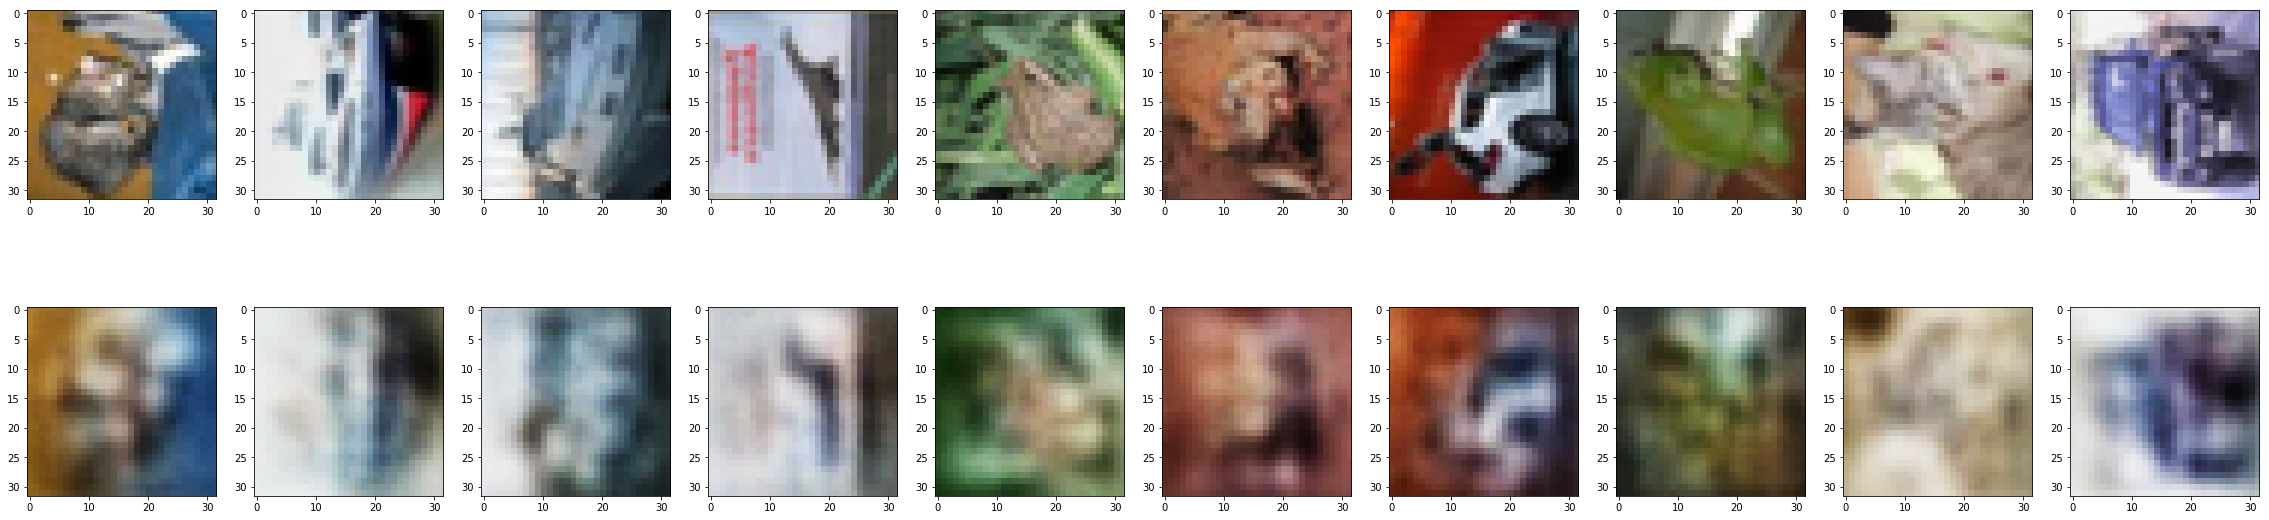

In [29]:
test_autoencoder()